<a href="https://colab.research.google.com/github/Joao-Girotto/Desafio-Python-Marvel/blob/main/Desafio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Instalações

In [1]:
!pip install dotenv

## Importações

In [46]:
import requests
import hashlib
import os
import time
import pandas as pd
import sqlite3
from dotenv import load_dotenv
import regex as re

## Pegando as chaves

In [3]:
load_dotenv()
PUBLIC_KEY = os.getenv("Public_Key")
PRIVATE_KEY = os.getenv("Private_Key")

## Endpoints e Parâmetros

In [117]:
ts = str(time.time())
to_hash = ts + PRIVATE_KEY + PUBLIC_KEY
hash_md5 = hashlib.md5(to_hash.encode()).hexdigest()

end1 = "https://gateway.marvel.com/v1/public/characters"
end2 = "https://gateway.marvel.com/v1/public/comics"
end3 = "https://gateway.marvel.com/v1/public/books"
end4 = "https://gateway.marvel.com/v1/public/series"
end5 = "https://gateway.marvel.com/v1/public/creators"

offset = 0
params = {
    "apikey": PUBLIC_KEY,
    "ts": ts,
    "hash": hash_md5,
    "limit": 100,
    "offset": offset
}

## Requisição

In [5]:
response = requests.get(end1, params=params)

response
data = response.json()
data
#df = pd.DataFrame(data['data']['results'])
#df.dtypes
# df_extraido = pd.json_normalize(df['data']['results'])
# df_extraido2 = pd.DataFrame(df['data']['results'])

{'code': 200,
 'status': 'Ok',
 'copyright': '© 2025 MARVEL',
 'attributionText': 'Data provided by Marvel. © 2025 MARVEL',
 'attributionHTML': '<a href="http://marvel.com">Data provided by Marvel. © 2025 MARVEL</a>',
 'etag': '0abb5390cb186d713808da3ee99124b68ecdcfd1',
 'data': {'offset': 0,
  'limit': 100,
  'total': 1564,
  'count': 100,
  'results': [{'id': 1011334,
    'name': '3-D Man',
    'description': '',
    'modified': '2014-04-29T14:18:17+0000',
    'thumbnail': {'path': 'http://i.annihil.us/u/prod/marvel/i/mg/c/e0/535fecbbb9784',
     'extension': 'jpg'},
    'resourceURI': 'https://gateway.marvel.com/v1/public/characters/1011334',
    'comics': {'available': 12,
     'collectionURI': 'https://gateway.marvel.com/v1/public/characters/1011334/comics',
     'items': [{'resourceURI': 'https://gateway.marvel.com/v1/public/comics/24571',
       'name': 'Avengers: The Initiative (2007) #14'},
      {'resourceURI': 'https://gateway.marvel.com/v1/public/comics/21366',
       'name

## Exibição

In [ ]:
# dsa = df_extraido['name']
df = df[['name', 'id', 'description']]
con = sqlite3.connect('Marvel.db')
df.to_sql("characters", con, if_exists="replace", index=False)
con.close()

## Consultando o Banco de Dados

In [ ]:
con2 = sqlite3.connect('Marvel.db')
df2 = pd.read_sql_query("SELECT * FROM characters", con2)
con2.close()
df2

,name,id,description
0,3-D Man,1011334,
1,A-Bomb (HAS),1017100,Rick Jones has been Hulk's best bud since day ...
2,A.I.M.,1009144,AIM is a terrorist organization bent on destro...
3,Aaron Stack,1010699,
4,Abomination (Emil Blonsky),1009146,"Formerly known as Emil Blonsky, a spy of Sovie..."
5,Abomination (Ultimate),1016823,
6,Absorbing Man,1009148,
7,Abyss,1009149,
8,Abyss (Age of Apocalypse),1010903,
9,Adam Destine,1011266,


## Consumindo todas as Series


In [16]:
def query(end):
  arraySeries = []
  offset = 0
  params['offset'] = offset
  max_tries = 5
  while True:
    tries = 0

    while tries < max_tries:
      try:
        response = requests.get(end,params=params)
        response.raise_for_status()
        data = response.json()

        if data.get('data', {}).get('results', []):
          arraySeries.append(data)
          break

        else:
          print('Falhou, tentando novamente')
          tries += 1
          continue

      except Exception as e:
        print('Tentando novamente, HTTP status code != 200')
        tries += 1
        continue

    if tries == max_tries:
        print('Offset falhou, pulando offset')
        offset += 100
        tries = 0
        params['offset'] = offset

    offset += 100
    tries = 0
    params['offset'] = offset
    print(offset)

    if offset >= data.get('data', {}).get('total', []):
      print('Query finalizada com sucesso')
      break
  return arraySeries

In [ ]:
dataFrameBackUp = pd.DataFrame(arraySeries)
dataFrameBackUp.to_csv('Series.csv')

## Adicionando as series ao banco de dados

In [ ]:
arraySeries = query(end4)

In [ ]:
def calculateDuration(row):
  if row['endYear'] == 2099:
    return 999
  else:
    return row['endYear'] - row['startYear']

def funcao_dict(x):
  creators = [item['name'] for item in x['items']] if isinstance(x, dict) and 'items' in x else []
  return ', '.join(creators)

def amount(x):
  return x.get('available', 0)

con = sqlite3.connect('Marvel.db')
for i in arraySeries:
  df = pd.DataFrame(pd.DataFrame(i['data']['results']))
  df['duration'] = df.apply(calculateDuration, axis=1)
  df['creator_name'] = df['creators'].apply(funcao_dict)
  df['character_qty'] = df['characters'].apply(amount)
  df['creator_qty'] = df['creators'].apply(amount)
  df['story_qty'] = df['stories'].apply(amount)
  df['event_qty'] = df['events'].apply(amount)
  df['comic_qty'] = df['comics'].apply(amount)
  df = df[['id', 'title', 'description', 'startYear', 'endYear',
           'rating', 'type', 'duration', 'creator_name', 'creator_qty',
           'character_qty', 'story_qty', 'event_qty', 'comic_qty']]
  df.to_sql("series", con, if_exists="append", index=False)
con.close()

In [6]:
con2 = sqlite3.connect('Marvel.db')
df2 = pd.read_sql_query("SELECT * FROM series", con2)
con2.close()
df2

,id,title,description,startYear,endYear,rating,type,duration,creator_name,creator_qty,character_qty,story_qty,event_qty,comic_qty
0,6026,(2008),None,2008,2008,Rated a,,0,"Joe Andreani, Rain Beredo, Chris Chuckry, Anto...",34,0,4,0,2
1,31445,Fantastic Four by Dan Slott Vol. 1 (2021),None,2021,2021,,collection,0,Jeff Youngquist,1,0,2,0,1
2,26024,Superior Spider-Man Vol. 2: Otto-matic (2019),None,2019,2019,,collection,0,"Christos Gage, Mike Hawthorne, Lan Medina, Jef...",4,1,2,0,1
3,18454,100th Anniversary Special (2014),None,2014,2014,Rated T,limited,0,"Andy Lanning, Sean Ryan, Jennifer Van Meter, I...",5,7,10,0,5
4,13379,15-Love (2011),None,2011,2011,,,0,"Tommy Ohtsuka, Andi Watson, Jordan D. White",3,0,9,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15695,1884,ZOMBIE (2007),None,2007,2007,Explicit Content,collection,0,,0,0,4,0,1
15696,23085,Zombies Assemble (2017),None,2017,2017,,,0,"Jim Campbell, David Curiel, Kiichi Mizushima, ...",12,6,16,0,4
15697,23388,Zombies Assemble 2 (2017),None,2017,2017,,,0,"Matteo Buffagni, Jim Charalampidis, Kiichi Miz...",12,7,18,0,4
15698,22383,ZOMBIES ASSEMBLE VOL. 1 (2017),None,2017,2017,,collection,0,Jeff Youngquist,1,7,2,0,1


## INSIGHT 1 Series: Quantidade de issues lançadas por ano

<Axes: title={'center': 'Quantidade de Séries começadas por ano'}, xlabel='startYear'>

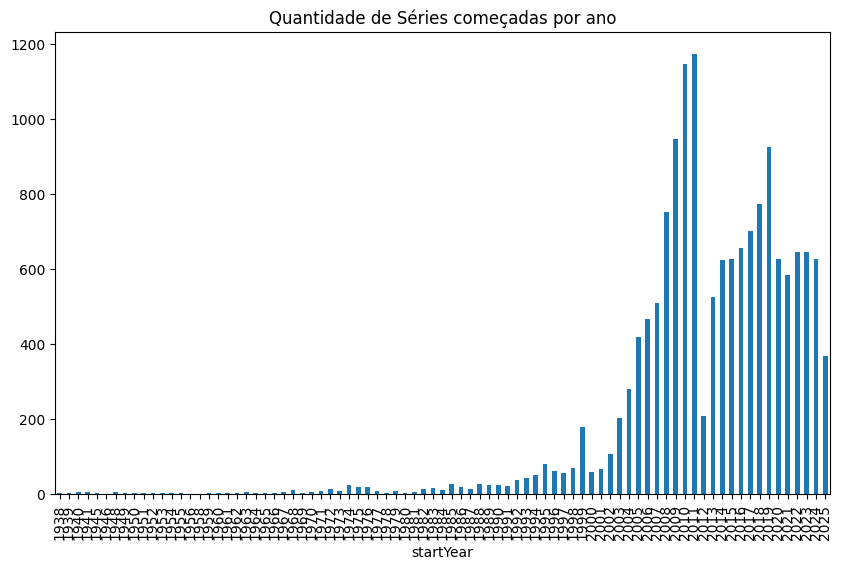

In [7]:
duration = df2[(df2['startYear'] > 0) & (df2['startYear'] < 2029)]['startYear'].value_counts().sort_index()
duration.plot(kind='bar', figsize=(10, 6), title='Quantidade de Séries começadas por ano')

## INSIGHT 2 Series: Média da duração (em anos) das series

In [ ]:
df2[(df2['duration'] >= 0) & (df2['duration'] < 999)]['duration'].value_counts().sort_index().head(10)
## 999 definido para séries em produção

,count
duration,
0,11688
1,959
2,207
3,80
4,54
5,18
6,22
7,13
8,11


In [ ]:
df2[(df2['duration'] >= 0) & (df2['duration'] < 999)]['duration'].mean()

np.float64(0.2838537699923839)

## INSIGHT 3 Series: Dados errados da API em relação a duração

In [ ]:
duration = df2['duration'].value_counts().sort_index()
df2[(df2['duration'] < 0) | (df2['duration'] > 999)]

,id,title,description,startYear,endYear,rating,type,duration,creator_name,creator_qty,character_qty,story_qty,event_qty,comic_qty
3599,7734,Electric Ant (0000 - 2010),None,0,2010,,,2010,"[Pascal Alixe, Lovern Kindzierski, Chris Sot...",8,0,39,0,6
3925,33956,Eternals: 500-Year War Infinity Comic (2029 - ...,"An international, all-star creative team of wr...",2029,2022,,,-7,"[Geoffo, Dan Abnett, Yifan Jiang, David Mac...",21,0,14,0,7
4622,25304,GET FURY (2029 - 2024),None,2029,2024,,collection,-5,[Jeff Youngquist],1,0,2,0,1
5990,5267,Iron Man: Director of S.H.I.E.L.D. (2008 - 2007),"Being one of the world's smartest, wealthiest ...",2008,2007,,,-1,"[Vc Joe Caramagna, Sean Chen, Steve Kurth, ...",15,1,19,2,8
7712,14745,Marvel Super Stars Magazine (2011 - 2010),None,2011,2010,,,-1,[Michael Turner],1,0,1,0,1
9094,13568,Official Handbook of the Ultimate Marvel Unive...,None,2010,2006,,,-4,"[Various, Mark Bagley, Morry Hollowell, Stu...",4,4,7,0,4
9095,13567,Official Handbook of the Ultimate Marvel Unive...,None,2010,2006,,,-4,[],0,0,0,0,0
9471,9932,Punisher Max: Tiny Ugly World (2013 - 2010),None,2013,2010,,,-3,"[David Lapham, Dalibor Talajic]",2,0,2,0,1
10160,3864,SHANNA THE SHE DEVIL: SURVIVAL OF THE FITTEST ...,None,2008,2007,Parental Advisory,,-1,[],0,0,4,0,1
11375,20133,Star Wars: Boba Fett (1997 - 1996),None,1997,1996,,,-1,"[Steve Dutro, Cam Kennedy, John Wagner]",3,0,2,0,1


## INSIGHT 4 Series: Média classificatória de faixa etária

In [ ]:
media = df2[df2['rating'] != '']['rating'].value_counts()
media

,count
rating,
Rated T+,606
All Ages,589
Marvel Psr,381
Rated a,354
Parental Advisory,239
T+,232
T,83
Rated T,69
Explicit Content,66


## INSIGTH 5 Series: Ranking dos tipos de séries

In [9]:
series_type = df2[df2['type'] != '']['type'].value_counts()
series_type

,count
type,
collection,6722
one shot,1897
ongoing,499
limited,204


## Adicionando as comics ao banco de dados

In [17]:
array = query(end2)

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
1850

In [18]:
df3 = pd.DataFrame(array)
df3.to_csv('Comics.csv')

In [44]:
def funcao_series(x):
  return x.get('name', '') if isinstance(x, dict) else ''

def funcao_price(x):
    if isinstance(x, list) and len(x) > 0 and isinstance(x[0], dict):
        return x[0].get('price', '')
    return ''

con = sqlite3.connect('Marvel.db')
for i in array:
  df = pd.DataFrame(pd.DataFrame(i['data']['results']))
  df['price'] = df['prices'].apply(funcao_price)
  df['series_name'] = df['series'].apply(funcao_series)
  df = df[['id', 'digitalId','title', 'issueNumber', 'description', 'format',
            'pageCount', 'series_name', 'price']]

  df.to_sql("comics", con, if_exists="append", index=False)
con.close()

## INSIGHT 1 Comics: Média de preço sobre o tempo

<ipython-input-115-c2528751b93b>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preco_sobre_tempo['year'] = preco_sobre_tempo[(preco_sobre_tempo['year'] > 1900) & (preco_sobre_tempo['year'] < 2050)]['year']


<Axes: title={'center': 'Média de preço'}, xlabel='year'>

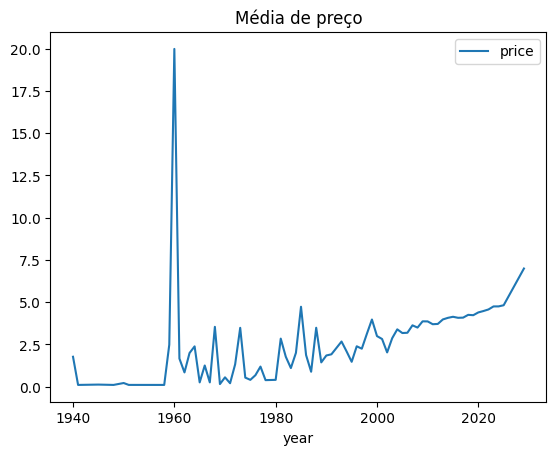

In [115]:
def extract_number(text):
  match = re.findall(r'\d+', text)
  return int(match[0]) if match else None

df3['year'] = df3['title'].apply(extract_number)
preco_sobre_tempo = df3[['year', 'price']]

preco_sobre_tempo['year'] = preco_sobre_tempo[(preco_sobre_tempo['year'] > 1900) & (preco_sobre_tempo['year'] < 2050)]['year']
preco_filtrado = preco_sobre_tempo.query('price > 0 and price < 25').copy()
preco_filtrado = preco_filtrado.dropna()
preco_filtrado_medio = preco_filtrado.groupby('year').mean()
preco_filtrado_medio.plot(title='Média de preço')

## INSIGHT 2 Comics: Média de páginas sobre o tempo

<ipython-input-111-b5d3a8e04d07>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pags_sobre_tempo['year'] = preco_sobre_tempo[(preco_sobre_tempo['year'] > 1900) & (preco_sobre_tempo['year'] < 2050)]['year']


<Axes: title={'center': 'Média de páginas'}, xlabel='year'>

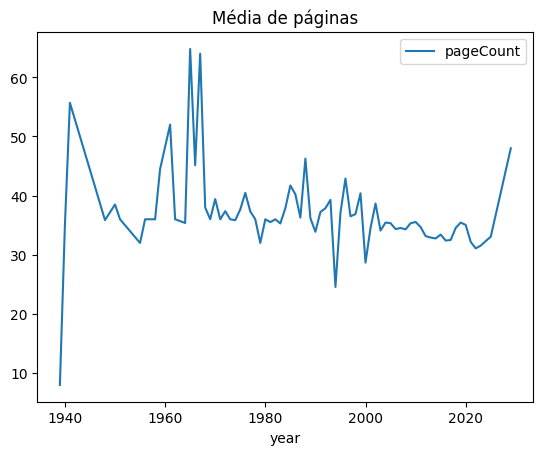

In [111]:
def extract_number(text):
  match = re.findall(r'\d+', text)
  return int(match[0]) if match else None

df3['year'] = df3['title'].apply(extract_number)
pags_sobre_tempo = df3[['year', 'pageCount']]
pags_sobre_tempo['year'] = preco_sobre_tempo[(preco_sobre_tempo['year'] > 1900) & (preco_sobre_tempo['year'] < 2050)]['year']
pags_filtrada = pags_sobre_tempo.query('pageCount > 0 and pageCount < 200')
pags_filtrada = pags_filtrada.dropna()
pags_filtrada_media = pags_filtrada.groupby('year').mean()
pags_filtrada_media.plot(title='Média de páginas')

## INSIGHT 3 Comics: Os formatos mais comuns

<Axes: title={'center': 'Distribuição mais comum de formatos'}, xlabel='format'>

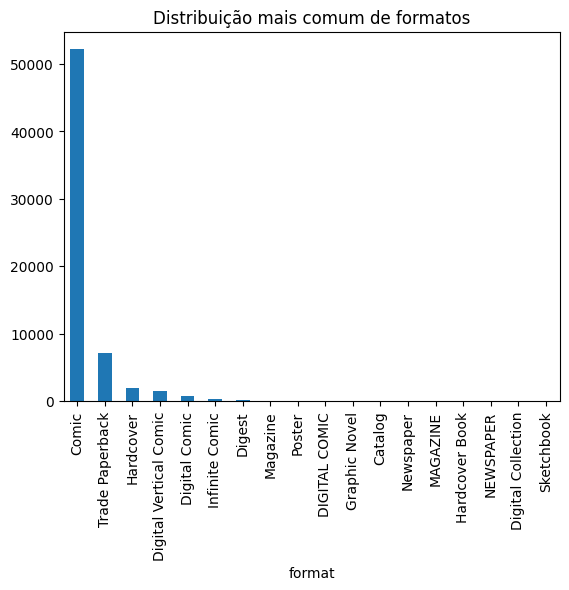

In [129]:
formatos = df3[df3['format'] != '']['format'].value_counts()
formatos.plot(kind='bar', title='Distribuição mais comum de formatos')